<a href="https://colab.research.google.com/github/VRachana2802/Exp-AI/blob/main/XAI_assign_5_lab(2335).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [ ]:
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [ ]:
import shap

In [ ]:
try:
    import lime
    from lime import lime_tabular
    has_lime = True
except Exception:
    has_lime = False

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
DATA_PATH = "co_emissions.csv"

In [ ]:
if not os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} not found. Please upload it.")
else:
    print(f"Using data from {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded. Shape:", df.shape)
    display(df.head())

co_emissions.csv not found. Please upload it.


In [ ]:
try:
    df_info = df.info()
except Exception:
    pass

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV (update the path/filename)
df = pd.read_csv("/content/Data.csv")

# look at the first few rows
print(df.head())
print(df.columns)


  Description         Name  year iso_code  population  gdp  cement_co2  \
0     Country  Afghanistan  1850      AFG   3752993.0  NaN         0.0   
1     Country  Afghanistan  1851      AFG   3767956.0  NaN         0.0   
2     Country  Afghanistan  1852      AFG   3783940.0  NaN         0.0   
3     Country  Afghanistan  1853      AFG   3800954.0  NaN         0.0   
4     Country  Afghanistan  1854      AFG   3818038.0  NaN         0.0   

   cement_co2_per_capita  co2  co2_growth_abs  ...  share_global_other_co2  \
0                    0.0  NaN             NaN  ...                     NaN   
1                    0.0  NaN             NaN  ...                     NaN   
2                    0.0  NaN             NaN  ...                     NaN   
3                    0.0  NaN             NaN  ...                     NaN   
4                    0.0  NaN             NaN  ...                     NaN   

   share_of_temperature_change_from_ghg  temperature_change_from_ch4  \
0             

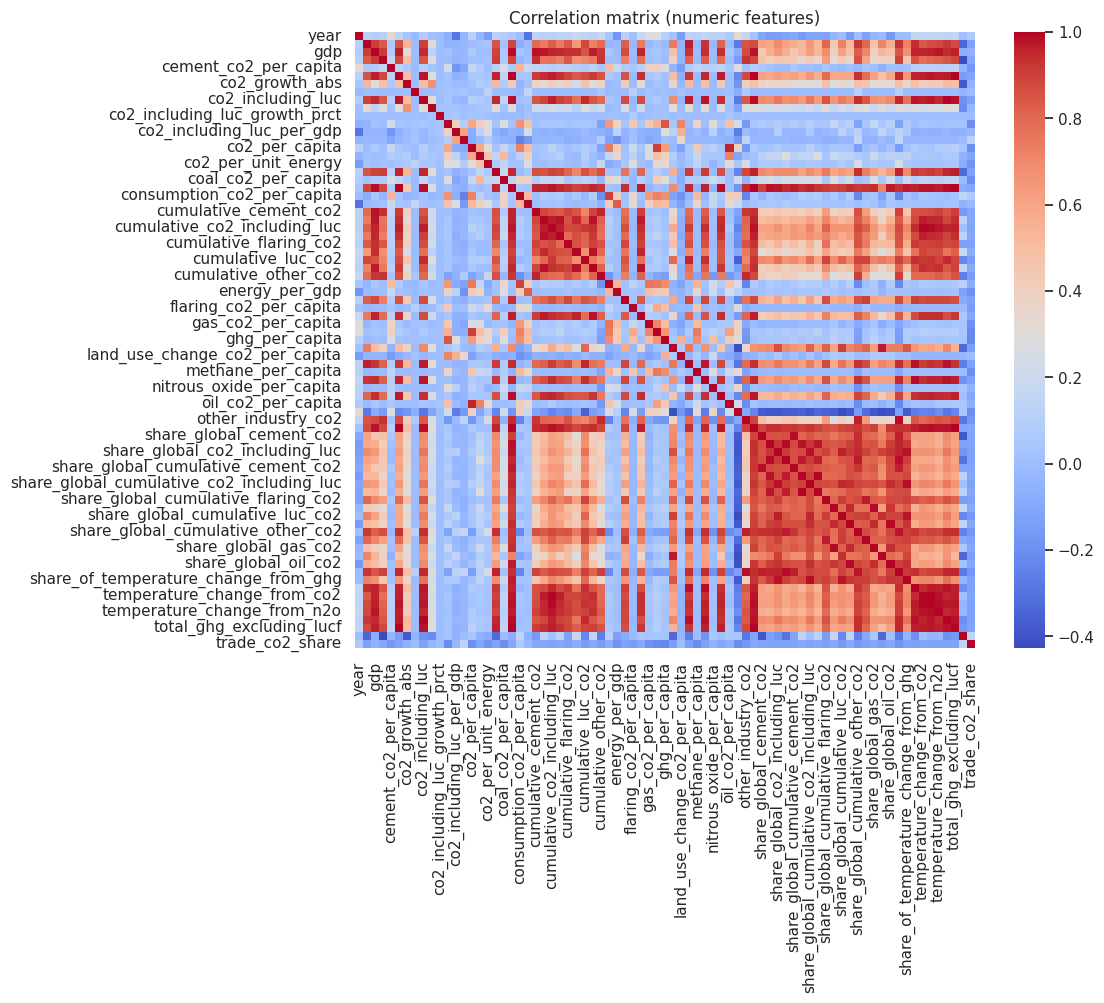

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Correlation matrix (numeric features)')
    plt.show()

In [ ]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Define target_col before using it
if 'CO2_emissions' in df.columns:
    target_col = 'CO2_emissions'
else:
    # try searching for plausible target columns
    candidates = [c for c in df.columns if 'co2' in c.lower() or 'emiss' in c.lower()]
    target_col = candidates[0] if candidates else df.columns[-1]
    print('Auto-selected target column:', target_col)

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target_col]

Auto-selected target column: cement_co2


In [ ]:
print('Categorical columns:', cat_cols)
print('Numerical columns:', num_cols)

Categorical columns: ['Description', 'Name', 'iso_code']
Numerical columns: ['year', 'population', 'gdp', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 'methane_per_capita', 'nitro

In [ ]:
if 'population' in df.columns:
    df['co2_per_capita'] = df[target_col] / (df['population'].replace({0: np.nan}))
    num_cols.append('co2_per_capita')

In [ ]:
for col in num_cols:
    if (df[col] > 0).all() and df[col].skew() > 1:
        df[col + '_log'] = np.log1p(df[col])
        num_cols.append(col + '_log')

In [ ]:
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

In [ ]:
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, num_cols),
('cat', categorical_transformer, cat_cols)
],
remainder='drop'
)

In [ ]:
all_cols = num_cols + cat_cols
unique_cols = list(set(all_cols))
X = df[unique_cols].copy()
y = df[target_col].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_feature_names = []
all_feature_names = num_cols + cat_feature_names
feature_names = list(set(all_feature_names))

In [ ]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
print('Processed train shape:', X_train_proc.shape)

Processed train shape: (34996, 553)


In [ ]:
models = {
'LinearRegression': LinearRegression(),
'Ridge': Ridge(alpha=1.0),
'Lasso': Lasso(alpha=0.01),
'DecisionTree': DecisionTreeRegressor(random_state=42),
'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
'SVR': SVR()
}

In [ ]:
if has_xgb:
    models['XGBoost'] = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [ ]:
input_shape = X_train_proc.shape[1]

In [ ]:
def build_mlp(input_dim):
    model = tf.keras.models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
def to_seq(X):
    return X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
X_train_seq = to_seq(X_train_proc.toarray())
X_test_seq = to_seq(X_test_proc.toarray())

In [ ]:
cnn = tf.keras.models.Sequential([
layers.Input(shape=(X_train_seq.shape[1], 1)),
layers.Conv1D(64, kernel_size=3, activation='relu'),
layers.Conv1D(32, kernel_size=3, activation='relu'),
layers.Flatten(),
layers.Dense(1, activation='linear')
])

In [ ]:
rf = models['RandomForest']
try:
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=feature_names)
    fi_sorted = fi.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    fi_sorted.plot(kind='bar')
    plt.title('Random Forest Top Feature Importances')
    plt.show()
except Exception as e:
    print('Could not compute feature importances:', e)

Could not compute feature importances: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

if len(feature_names) >= 1:
    feat_idx = 0 # change to a meaningful feature index (e.g., index of 'coal' usage)
    try:
        display = PartialDependenceDisplay.from_estimator(rf, X_test_proc, [feat_idx], feature_names=feature_names)
        # Display the plot
        display.figure_.suptitle(f"Partial Dependence Plot for Feature: {feature_names[feat_idx]}")
        plt.show()
    except Exception as e:
        print('PDP failed:', e)

PDP failed: feature_names should not contain duplicates.


In [ ]:
cnn_preds = cnn.predict(X_test_seq).flatten()

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [ ]:
import numpy as np
print("NaNs in y_test_valid_cnn:", np.isnan(y_test_valid_cnn).sum())
print("NaNs in cnn_preds_valid:", np.isnan(cnn_preds_valid).sum())

NaNs in y_test_valid_cnn: 0
NaNs in cnn_preds_valid: 4706


In [ ]:
y_filled = np.nan_to_num(y_test_valid_cnn, nan=0.0)
pred_filled = np.nan_to_num(cnn_preds_valid, nan=0.0)
